# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [39]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# libwallerlab = True

# if libwallerlab:
#     # Load motiondeblur module and Dataset class
#     import libwallerlab.projects.motiondeblur as md
#     from libwallerlab.utilities.io import Dataset, isDataset
# else:
#     import htdeblur as md
#     from comptic.containers import Dataset, isDataset
#     from htdeblur.mddataset import MotionDeblurDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

# import arrayfire as af
# af.set_backend('opencl')

# yp.config.setDefaultBackend('numpy') #'arrayfire')
# yp.config.setDefaultDatatype('float32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
!pwd

/home/deansarah/deblurring/htdeblur/notebooks/reconstructions


```
reg="tv"; for val in 1e-5 1e-4 1e-3 1e-2; do echo "{'$reg':$val} " & done;
reg="tv"; for val in 1e-5 1e-4 1e-3 1e-2; do python /home/deansarah/deblurring/htdeblur/notebooks/reconstructions/snr_comparison_recon_regularization_beads_res.py --beads 1 --reg-type "{'$reg':$val} " & done;

reg="l2"; for val in 1e-5 1e-4 1e-3 1e-2; do python /home/deansarah/deblurring/htdeblur/notebooks/reconstructions/snr_comparison_recon_regularization_beads_res.py --beads 1 --reg-type "{'$reg':$val} " & done;

reg="haar_wavelet"; for val in 1e-5 1e-4 1e-3 1e-2; do python /home/deansarah/deblurring/htdeblur/notebooks/reconstructions/snr_comparison_recon_regularization_beads_res.py --beads 1 --reg-type "{'$reg':$val} " & done;

reg="tsvd"; for val in 1e1 1e2 1e3 1e4; do python /home/deansarah/deblurring/htdeblur/notebooks/reconstructions/snr_comparison_recon_regularization_beads_res.py --beads 1 --reg-type "{'$reg':$val} " & done;


python /home/deansarah/deblurring/htdeblur/notebooks/reconstructions/snr_comparison_recon_regularization_beads_res.py --beads 0 --reg-type "{'tv':1e-3}"
1e-3,5e-4,1e-4,5e-5,1e-5

python /home/deansarah/deblurring/htdeblur/notebooks/reconstructions/snr_comparison_recon_regularization_beads_res.py --beads 1 --reg-type "{'l2':1e-4}"
1e-3,5e-4,1e-4,5e-5,1e-5

python /home/deansarah/deblurring/htdeblur/notebooks/reconstructions/snr_comparison_recon_regularization_beads_res.py --beads 0 --reg-type "{'haar_wavelet':1e-4}"
1e-3,5e-4,1e-4,5e-5,1e-5

python /home/deansarah/deblurring/htdeblur/notebooks/reconstructions/snr_comparison_recon_regularization_beads_res.py --beads 1 --reg-type "{'tsvd':100}"
100,500

```

In [75]:
!python snr_comparison_recon_regularization_beads_res.py --beads 0 --reg-types "{'tv':1e-2} " --ss 1

Namespace(beads=0, reg_types={'tv': 0.01}, ss=1.0)
/home/deansarah/Dropbox/res_line_bright_coded_raster_100_motion_deblur_2019_02_05_10_52_50
Loading 1 frames...
Loading 4 frames...
Minimizing function:
<IPython.core.display.Latex object>
|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    3.59e+14    |       0.00       |    0.00e+00    | 4150.5 MB /    0.0 MB  |
|   10   |    2.28e+11    |      91.42       |    1.05e+04    | 5979.5 MB /    0.0 MB  |
^C
Traceback (most recent call last):
  File "snr_comparison_recon_regularization_beads_res.py", line 76, in <module>
    main(args)
  File "snr_comparison_recon_regularization_beads_res.py", line 61, in main
    recon.reconstruct(iteration_count=nit, step_size=ss, mode='global', reg_types=args.reg_types)
  File "/home/deansarah/deblurring/libwallerlab/libwallerlab/projects/motiondeblur/recon.py", line

In [71]:
output_path = os.path.expanduser('~/deblurring/datasets/regularized_output')
old_data_path ='/home/deansarah/Dropbox/deblurring/reconstruction_results/snr_fig/'
beads=True

<IPython.core.display.Javascript object>


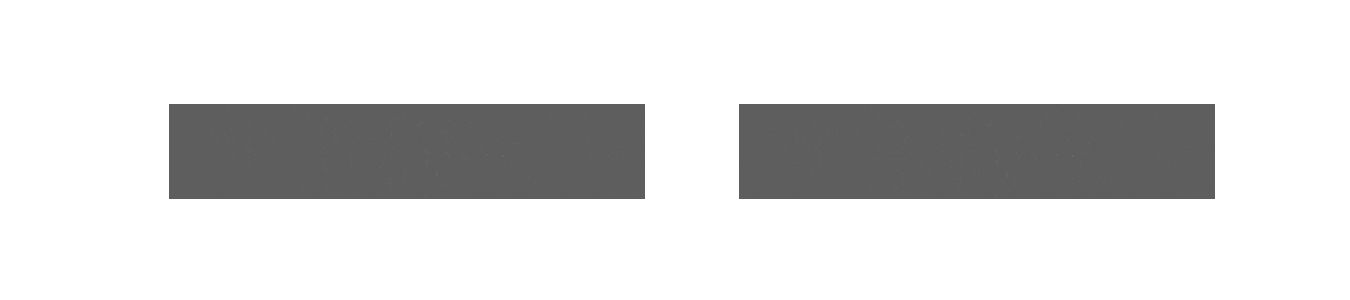

(-14859.713, 26497.113)
(-14779.384, 26397.186)


In [76]:
if beads:
    reg = '[l21.0e-05]'
    filename_old = 'beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36_no_median_regularize=[].npz'
    filename_new = 'beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36_reprocess_regularize={}.npz'.format(reg)
else:
    filename_old = 'res_line_bright_coded_raster_100_motion_deblur_2019_02_05_10_52_50_reprocess_regularize=[].npz'
    filename_new = filename_old
    
data_old = np.load(os.path.join(old_data_path, filename_old))
data_new = np.load(os.path.join(output_path, filename_new))


plt.figure(figsize=(9,2))
plt.subplot(121)
plt.imshow(data_old['object_recovered'],cmap='gray')
plt.axis('off')
print(plt.gci().get_clim())

plt.subplot(122)
plt.imshow(data_new['object_recovered'],cmap='gray')
plt.axis('off')
print(plt.gci().get_clim())


In [77]:
data_old['object_recovered']-data_new['object_recovered']

array([[ 2.1362305e-04,  2.7465820e-03, -3.3569336e-04, ...,
        -1.0623856e+00, -1.1424866e+00,  3.7293701e+00],
       [-6.1035156e-04,  9.7961426e-03,  1.7059326e-02, ...,
         2.3512573e+00, -1.3717651e-02, -6.7328548e-01],
       [ 1.5594482e-02,  2.5939941e-03,  6.5002441e-03, ...,
         2.8707886e-01,  1.2144165e+00,  1.2325745e+00],
       ...,
       [ 9.5520020e-03,  9.6435547e-03,  7.1716309e-03, ...,
         3.1219482e-01, -7.4993896e-01, -3.9712524e-01],
       [ 9.8876953e-03,  6.5917969e-03,  1.6418457e-02, ...,
        -8.8180542e-01, -1.1977386e+00, -1.8179321e-01],
       [ 4.7912598e-03,  4.3029785e-03,  1.2847900e-02, ...,
        -3.0691895e+01, -1.6585449e+01,  4.8518066e+00]], dtype=float32)

<IPython.core.display.Javascript object>


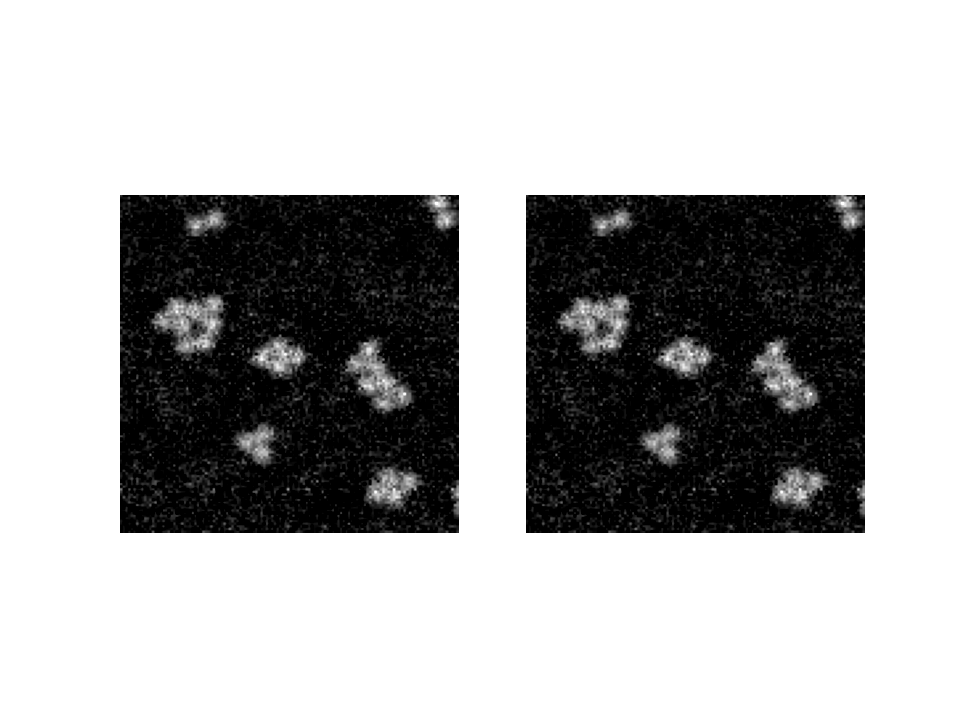

In [78]:
if beads:

    plt.figure()
    plt.subplot(121)
    beads_roi_crop_B = yp.Roi(start=(1178-32+10, 4049+10), shape=(128, 128))
    plt.imshow(data_old['object_recovered'][beads_roi_crop_B.slice], cmap='gray')
    plt.axis('off')
    plt.clim(400,3000)

    plt.subplot(122)
    plt.imshow(data_new['object_recovered'][beads_roi_crop_B.slice], cmap='gray')
    plt.axis('off')
    plt.clim(400,3000)
    
else:
    res_roi_crop_B_1 = yp.Roi(start=(1000-75,4950-25), shape=(300,300))
    plt.figure()
    plt.subplot(121)
    plt.imshow(data_old['object_recovered'][res_roi_crop_B_1.slice], cmap='gray')
    plt.axis('off')
    plt.clim(-1,2)

    plt.subplot(122)
    plt.imshow(data_new['object_recovered'][res_roi_crop_B_1.slice], cmap='gray')
    plt.axis('off')
    plt.clim(-8000,20000)
